<a href="https://colab.research.google.com/github/drwitt/BME_590_Tensorflow_Deep_Learning/blob/master/BME_Project_3_Baseline_Retinopathy_Model_ResNet_TTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BME Project 3: Retinopathy Model + Option for ResNet with TTA (saved weights)**



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
cd /content/

/content


In [0]:
#Clone LCA forked and edited repo into /content/ directory:
!git clone https://github.com/drwitt/loss-change-allocation.git

Cloning into 'loss-change-allocation'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 127 (delta 61), reused 101 (delta 37), pack-reused 0
Receiving objects: 100% (127/127), 70.54 KiB | 785.00 KiB/s, done.
Resolving deltas: 100% (61/61), done.


In [0]:
#Check for git cloned LCA directory (LCA files at: dir = '/content/loss-change-allocation/):
ls

gdrive/  loss-change-allocation/  sample_data/


In [0]:
#Update current working directory to the git cloned repo (/loss-change-allocation):
cd /content/loss-change-allocation/

/content/loss-change-allocation


# **Implement LCA: Dev Area**

In [0]:
#Need to install and import:
!pip install orderedset

     |████████████████████████████████| 102kB 5.1MB/s 
  Created wheel for orderedset: filename=orderedset-2.0.1-cp36-cp36m-linux_x86_64.whl size=250001 sha256=563cc1869abe6d2ced077cb3d64b92db0183b88a0f79c8c3623920632d813ccf
  Stored in directory: /root/.cache/pip/wheels/68/1a/0a/084d78f38459b3111414732e471b0cfbdf05b1931550f60ada
Successfully built orderedset


In [8]:
#Train model:

#Note, data_dir flag uses google drive directory set up. Mine is configured as 
#follows: '/content/gdrive/My Drive/BME_Project_3_LCA_viz/data/'

#Inside ../data/ exist the train.csv, test.csv, train/ directory containing
#images (in .png format)

!python train.py --data_dir '/content/gdrive/My Drive/BME_Project_3_LCA_viz/data/' \
--class_label_count 5 \
--opt sgd \
--lr 0.1 \
--save_weights \
--num_epochs 5 \
--eval_every 100 \
--print_every 100 \
--log_every 50 \
--tf_seed 7 \
--output_dir '/content/gdrive/My Drive/BME_Project_3_LCA_viz/outputs'








Using TensorFlow backend.

Training set has 3662 samples
Testing set has 1928 samples
Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.cast` instead.


All model weights:
                                                NAME:       SIZE SHAPE               
                sequential_network/conv2D_1/kernel:0:        192 [2, 2, 3, 16]       
                  sequential_network/conv2D_1/bias:0:         16 [16]                
                sequential_network/conv2D_2/kernel:0:       2048 [2, 2, 16, 32]      
                  sequential_network/conv2D_2/bias:0:         32 [32]                
                sequential_network/conv2D_3/kernel:0:       8192 [2, 2, 32, 64]      
       

# **Baseline Model Set Up**

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
SEED = 7
np.random.seed(SEED)
set_random_seed(SEED)
dir_path =  '/content/gdrive/My Drive/BME_Project_3_LCA_viz/' + 'data/'
IMG_DIM = 299  # 224 399 #
BATCH_SIZE = 12
CHANNEL_SIZE = 3
NUM_EPOCHS = 10
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

In [0]:
df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))

NUM_CLASSES = df_train['diagnosis'].nunique()

In [0]:
print("Training set has {} samples".format(df_train.shape[0]))
print("Testing set has {} samples".format(df_test.shape[0]))

Training set has 3662 samples
Testing set has 1928 samples


In [0]:
def append_ext(fn):
    return fn+".png"

df_train["id_code"]= df_train["id_code"].apply(append_ext)

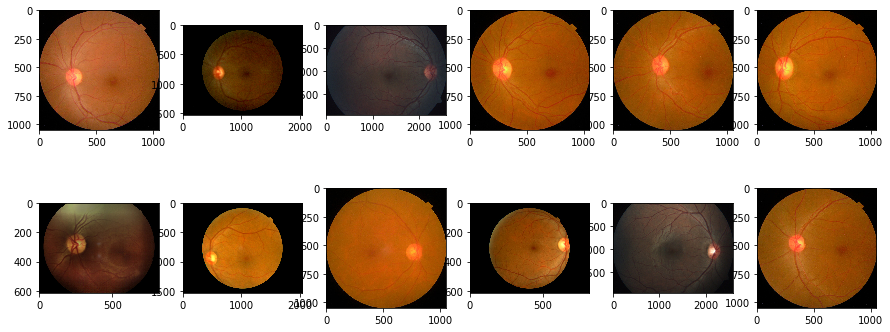

In [0]:
CLASS_ID = 0
imgs = df_train[df_train.diagnosis == CLASS_ID].head(12)

fig, axis = plt.subplots(2, 6, figsize=(15, 6))
for idnx, (idx, row) in enumerate(imgs.iterrows()):
    imgPath = os.path.join(dir_path, 'train/{}'.format(row['id_code']))
    img = cv2.imread(imgPath)
    row = idnx // 6
    col = idnx % 6
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axis[row, col].imshow(img)

In [0]:
#For some reason the generator wants diagnostic labels in string form:

df_train['diagnosis'] = df_train['diagnosis'].astype(str)

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    validation_split=0.20)

In [0]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= dir_path+TRAIN_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=SEED,
                                                    )

valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= dir_path+TRAIN_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=SEED
                                                    )

gc.collect()

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


22

In [0]:
x = train_generator[3][1]

In [0]:
x

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
def design_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[IMG_DIM, IMG_DIM, CHANNEL_SIZE], activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(5, activation='softmax'))
    return model


model = design_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 73, 73, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         


In [0]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=3, 
                           verbose=1, 
                           mode='auto'
                          )

# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              min_delta=0.0004, 
                              patience=2, 
                              factor=0.1, 
                              min_lr=1e-6, 
                              mode='auto',
                              verbose=1
                             )

In [0]:
NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUM_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUM_TRAIN_STEPS, NUM_VALID_STEPS

(244, 61)

In [0]:
# #Convert Keras model to TPU model:
# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#         model,
#         strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://'    + os.environ['COLAB_TPU_ADDR'])
#         )
#     )
# tpu_model.compile(
#         optimizer=tf.train.AdamOptimizer(learning_rate=5e-2),
#         loss= tf.keras.losses.sparse_categorical_crossentropy,
#         metrics=['sparse_categorical_accuracy']
#     )
# checkpoint_path = "path/weights.{epoch:02d}-{val_loss:.2f}.hdf5"                             
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#         checkpoint_path, verbose=1, save_weights_only=True,
#         period=5)

In [0]:
history = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUM_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUM_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     callbacks=[early_stop, reduce_lr],
                                     verbose=1)

Epoch 1/60
244/244 [==============================] - 2521s 10s/step - loss: 1.0739 - acc: 0.5919 - val_loss: 1.2307 - val_acc: 0.5902
Epoch 2/60
244/244 [==============================] - 456s 2s/step - loss: 0.8559 - acc: 0.7012 - val_loss: 0.8504 - val_acc: 0.6954
Epoch 3/60
244/244 [==============================] - 454s 2s/step - loss: 0.8263 - acc: 0.7111 - val_loss: 0.8216 - val_acc: 0.7022
Epoch 4/60
244/244 [==============================] - 454s 2s/step - loss: 0.8220 - acc: 0.7148 - val_loss: 0.8543 - val_acc: 0.7008
Epoch 5/60
244/244 [==============================] - 448s 2s/step - loss: 0.8167 - acc: 0.7114 - val_loss: 0.8031 - val_acc: 0.7090
Epoch 6/60
244/244 [==============================] - 446s 2s/step - loss: 0.8145 - acc: 0.7145 - val_loss: 0.8256 - val_acc: 0.7131
Epoch 7/60
244/244 [==============================] - 448s 2s/step - loss: 0.7896 - acc: 0.7240 - val_loss: 0.8197 - val_acc: 0.7172

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001000

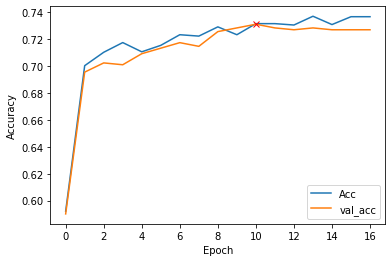

In [0]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

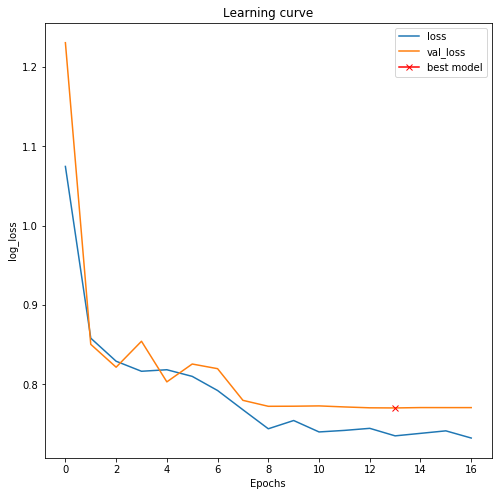

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=valid_generator, steps=NUM_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=61, use_multiprocessing=False)`
  
100%|██████████| 2/2 [00:00<00:00, 447.42it/s]

[INFO] accuracy: 72.68%
[INFO] Loss: 0.7706083066639353


In [0]:
#Save model:

model.save('/content/gdrive/My Drive/BME_Project_3_LCA_viz/Baseline_CNN_Retinopathy_Classification_Model.h5')

# **ResNet Option**

In [0]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights(dir_path +'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet


model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

In [0]:
for layers in model_resnet.layers:
    layers.trainable = True

In [0]:
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # Adam(lr=lr, decay=0.01) 
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_resnet.summary()
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

367

In [0]:
history = model_resnet.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUM_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUM_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     callbacks=[early_stop, reduce_lr],
                                     verbose=2)
gc.collect()

In [0]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
(eval_loss, eval_accuracy) = tqdm(
    model_resnet.evaluate_generator(generator=valid_generator, steps=NUM_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
